# DataLab Cup 3: Reverse Image Caption
<hr>

Platform: [Kaggle](https://www.kaggle.com/c/datalab-cup3-reverse-image-caption-2022f)

Team Name: 沒liao恩宇

Team Member: 110062560 林子鵑、110062802 呂宸漢、110062552 周伯宇


## I. Caption Encoding

由於這次的competition是要將image caption轉成對應的image，因此需要將image caption做encoding。以下列出我們有嘗試過的兩種encode方式：

* **RNN Encoder**

    採用助教在notebook上所使用的RNN Encoder將caption encode成長度為256的tensor。

* **Sentence-Transformers**

    採用[Sentence-Transformers](https://www.sbert.net/)當作我們的caption encoder，由於助教給的dataset已經將caption編碼成數字，因此我們會先利用助教附上的`id2Word.npy`將caption轉回文字並透過Sentence-Transformers進行編碼，在這些[Pretrained Models](https://www.sbert.net/docs/pretrained_models.html)中可以看到`all-mpnet-base-v2`的效果最佳，因此我們就以此為encoder將caption encode成長度為768的tensor。

經過我們的實驗發現，其實這兩種方法encode出來的caption對於我們的model而言並沒有太大的影響，不確定是因為我們model不夠好沒辦法正確反映caption的差異或是真的不影響結果，因此我們還是先以Sentence-Transformers為我們的caption encoder。


## II. Dataset

原先助教的範例code每一張圖片都只random取一個caption作為training的image caption，不過這樣會損失許多可能會幫助訓練的訓練資料，因此我們直接將所有caption跟image加入dataset，雖然會使同一張圖片在一個epoch內被看到不止一次，不過考量到多個epoch在random取caption後也是一樣效果，因此我們認為直接展開是沒有問題的。


## III. Data Augmentation

如同上一節所提到，同一張image在一個epoch會被看到許多次，為了增加data的多樣性，我們採用`tf.image.flip_left_right`與`tf.image.random_brightness`對我們的圖片做augmentation，由於caption會指定花的顏色，因此我們不使用會改變顏色的augmentation。在我們的實驗發現，augmentation的程度也會影響training的結果，當augmentation的機率太高或太低時，training的結果都會變得很爛，在此我們以0.25做為要不要augmentation的threshold。


## IV. Generative Adversarial Network Model

### DCGAN with WGAN-GP

* **Architecture**

    我們參考了[DCGAN](https://github.com/carpedm20/DCGAN-tensorflow)的架構作為我們的GAN model，由於原始的DCGAN的input只有noise，沒有condition可以控制要生成的圖片類別，因此我們自己加入了embedding到GAN裡面。在generator的部份我們先將encode後的caption餵進一層dense layer做embedding，再與noise連接在一起並透過一層dense layer與四層deconvolution layer長成64x64x3的圖片。在discriminator的部分我們則是分別將caption與image餵進與generator類似架構的layer裡面，將兩個output的tensor連接起來後再經過convolution layer做最後的判斷。

* **Loss Function**

    我們使用[WGAN-GP](https://github.com/caogang/wgan-gp)做為我們的loss function並搭配noise decay的技術來訓練我們的model。根據我們的實驗結果，noise decay有小幅度的提升我們model的performance。根據老師上課所述，conditional GAN的loss function若沒有增加wrong caption讓discriminator知道image與caption對不起來也是錯的的話，generator與discriminator可能會聯合起來不管caption，因此我們也有嘗試加入wrong caption搭配real image讓discriminator學習，不過不知道是我們的寫法問題或是架構問題，再加入wrong caption後很常在沒train多久之後圖片就爛掉了，無論我們怎麼調整參數或是loss的比例都沒有找到一個平衡點，因此我們最後的版本便沒有使用wrong caption下去training。

* **Optimizer**

    我們使用Adam作為generator與discriminator的optimizer，並參考[WGAN-GP](https://github.com/caogang/wgan-gp)的設定將learning_rate、beta_1與beta_2設成[0.0001, 0.5, 0.999]進行訓練。在實驗過程中我們也有嘗試不同的optimizer，如：RMSProp，也嘗試過另一組參數設定[0.0001, 0, 0.9]，不過在這些組合中還是Adam搭配[0.0001, 0.5, 0.999]有較好的成果。

* **Training Strategy**

    在training strategy的設定上我們也嘗試了許久，從discriminator與generator的比例為1:1到5:1我們都嘗試過，最後我們選擇2:1最為最後的設定。


### StackGAN

* **Architecture**

    另外我們也嘗試參考了[StackGAN](https://arxiv.org/abs/1612.03242)的架構做為我們的GAN model，主要想解決cGAN沒辦法產生256x256高畫質的大圖的問題，希望將generator分成兩階段來生成圖片，stage-I先產生64x64的小圖，stage-II再產生256x256的大圖。而在stage-I就是標準的cGAN，特別的是除了embedding之外再接了一個dense layer得到Gaussian distribution中的mean和variance，並從中sample出要使用的condition $\hat{c_0}$ ，再與 $N_z$ 維的noise相連接作爲generator的input，generator是使用多個upsampling加上convolution layer來生成64x64x3的圖片，而discriminator則是使用多個down-sampling的結果與resize過後的embedding連接後，再接一層dense layer。stage-II的generator則沒有noise加入，使用stage-I生成的圖片做down-sampling之後連接replicated的 $\hat{c_0}$ 作為input，再經過多個residual blocks並和stage-I相同的up-sampling方式生成256x256x3圖片，discriminator則和stage-I相似。  
    
    <!-- ![](stackGAN.png) -->

* **Loss Function**

    我們以StackGAN paper中敘述實作loss function，透過交替 maximize $L_D$ 和 minimize $L_G$ 來train generator及discriminator，由以下公式定義：  
    - Stage-I : 其中 $\varphi_t$ 是embedding，$z$ 為noise(sampled from Gaussian distribution $p_z$)，$I_0$ 為real image，$\lambda$=1。  
    $L_{D_0}=\mathop{\mathbb{E}}_{({I_0},t)\sim p_{data}}[logD_0(I_0,\varphi_t)]+\mathop{\mathbb{E}}_{z\sim p_z,t\sim p_{data}}[log(1-D_0(G_0(z,\hat{c_0}),\varphi_t))]$  
    $L_{G_0}=\mathop{\mathbb{E}}_{z\sim p_z,t\sim p_{data}}[log(1-D_0(G_0(z,\hat{c_0}),\varphi_t))]+\lambda D_{KL}(N(\mu_0(\varphi_t),\Sigma_0(\varphi_t))||N(0,I))$  
      
    - Stage-II : 其中 $s_0$ 是stage1的生成圖片。  
    $L_D=\mathop{\mathbb{E}}_{(I,t)\sim p_{data}}[logD(I,\varphi_t)]+\mathop{\mathbb{E}}_{s_0\sim p_{G_0},t\sim p_{data}}[log(1-D(G(s_0,\hat{c}),\varphi_t))]$  
    $L_G=\mathop{\mathbb{E}}_{s_0\sim p_{G_0},t\sim p_{data}}[log(1-D(G(s_0,\hat{c}),\varphi_t))]+\lambda D_{KL}(N(\mu(\varphi_t),\Sigma(\varphi_t))||N(0,I))$

* **Optimizer**   

    我們根據stackGAN paper中所提及實作細節，使用Adam作爲generator及discriminator的optimizer，並參考stackGAN的設定，將learning rate、beta_1與beta_2設成[0.0002, 0.5, 0.999]進行訓練。

* **Training Strategy**  

    在training stretegy上，若最終生成256x256x3的圖片會導致memory爆掉的情況，所以我們將stage-II的輸出調整成64x64，但可能架構沒有寫好導致最終的效果不佳。另外也有想過將stage-I輸出變成16x16，stage-II調整成輸出64x64的圖片，但礙於時間限制而沒有達成這部分的實作。

以上是我們有嘗試過的兩種不同model架構與對應的training方法，以結果而言兩者產出的圖片品質類似，因此我們最終取架構較簡單的DCGAN作為最終的model。

## V. Conclusion

藉由這次competition讓我們明白一件事，就是GAN真的很難train，有太多需要注意的地方，無論是model的設計、loss function的計算以及參數的設定都會大幅影響最後的結果，與competition 2最大的差別在於上次只要長得出框框就好，這次是要長出一張對應的圖片，只要差一些些就會讓結果爛掉，真的需要多去參考別人的架構與多看一些前人的經驗才能有更好的結果。雖然這次competition的時間給了一個月，不過在GAN的lab作業下來與開始時做cGAN還是拖到比較晚才開始做，一方面覺得可以用train lab作業的經驗套在train cGAN上面，因此花了較多時間在觀察不同設定對lab人臉的影響，想說在train cGAN就會比較順利，結果實際下去做才發現根本不是這麼一回事，等到我們明白這件事的時候已經為時已晚，或許我們早點開始去survey其他paper的做法，也許就能像前幾次competiton的結果一樣可以得到較前面的名次。


## VI. Generated Image

下圖是利用我們train好的model在5個testing caption上用5種不同的random noise所生出來的結果，可以看到我們的model有正確辨認顏色並生出花，其中又以Noise2的花與caption最接近。由下表可以看出Noise對最後的成績也有很大的影響，好的noise可以生出較好的花且花的長相也比較接近caption。

| Noise  | Noise1 | Noise2 | Noise3 | Noise4 | Noise5 |
| ---    | ---    | ---    | ---    | ---    | ---    |
| Score  | 0.512  | 0.492  | 0.501  | 0.526  | 0.523  |

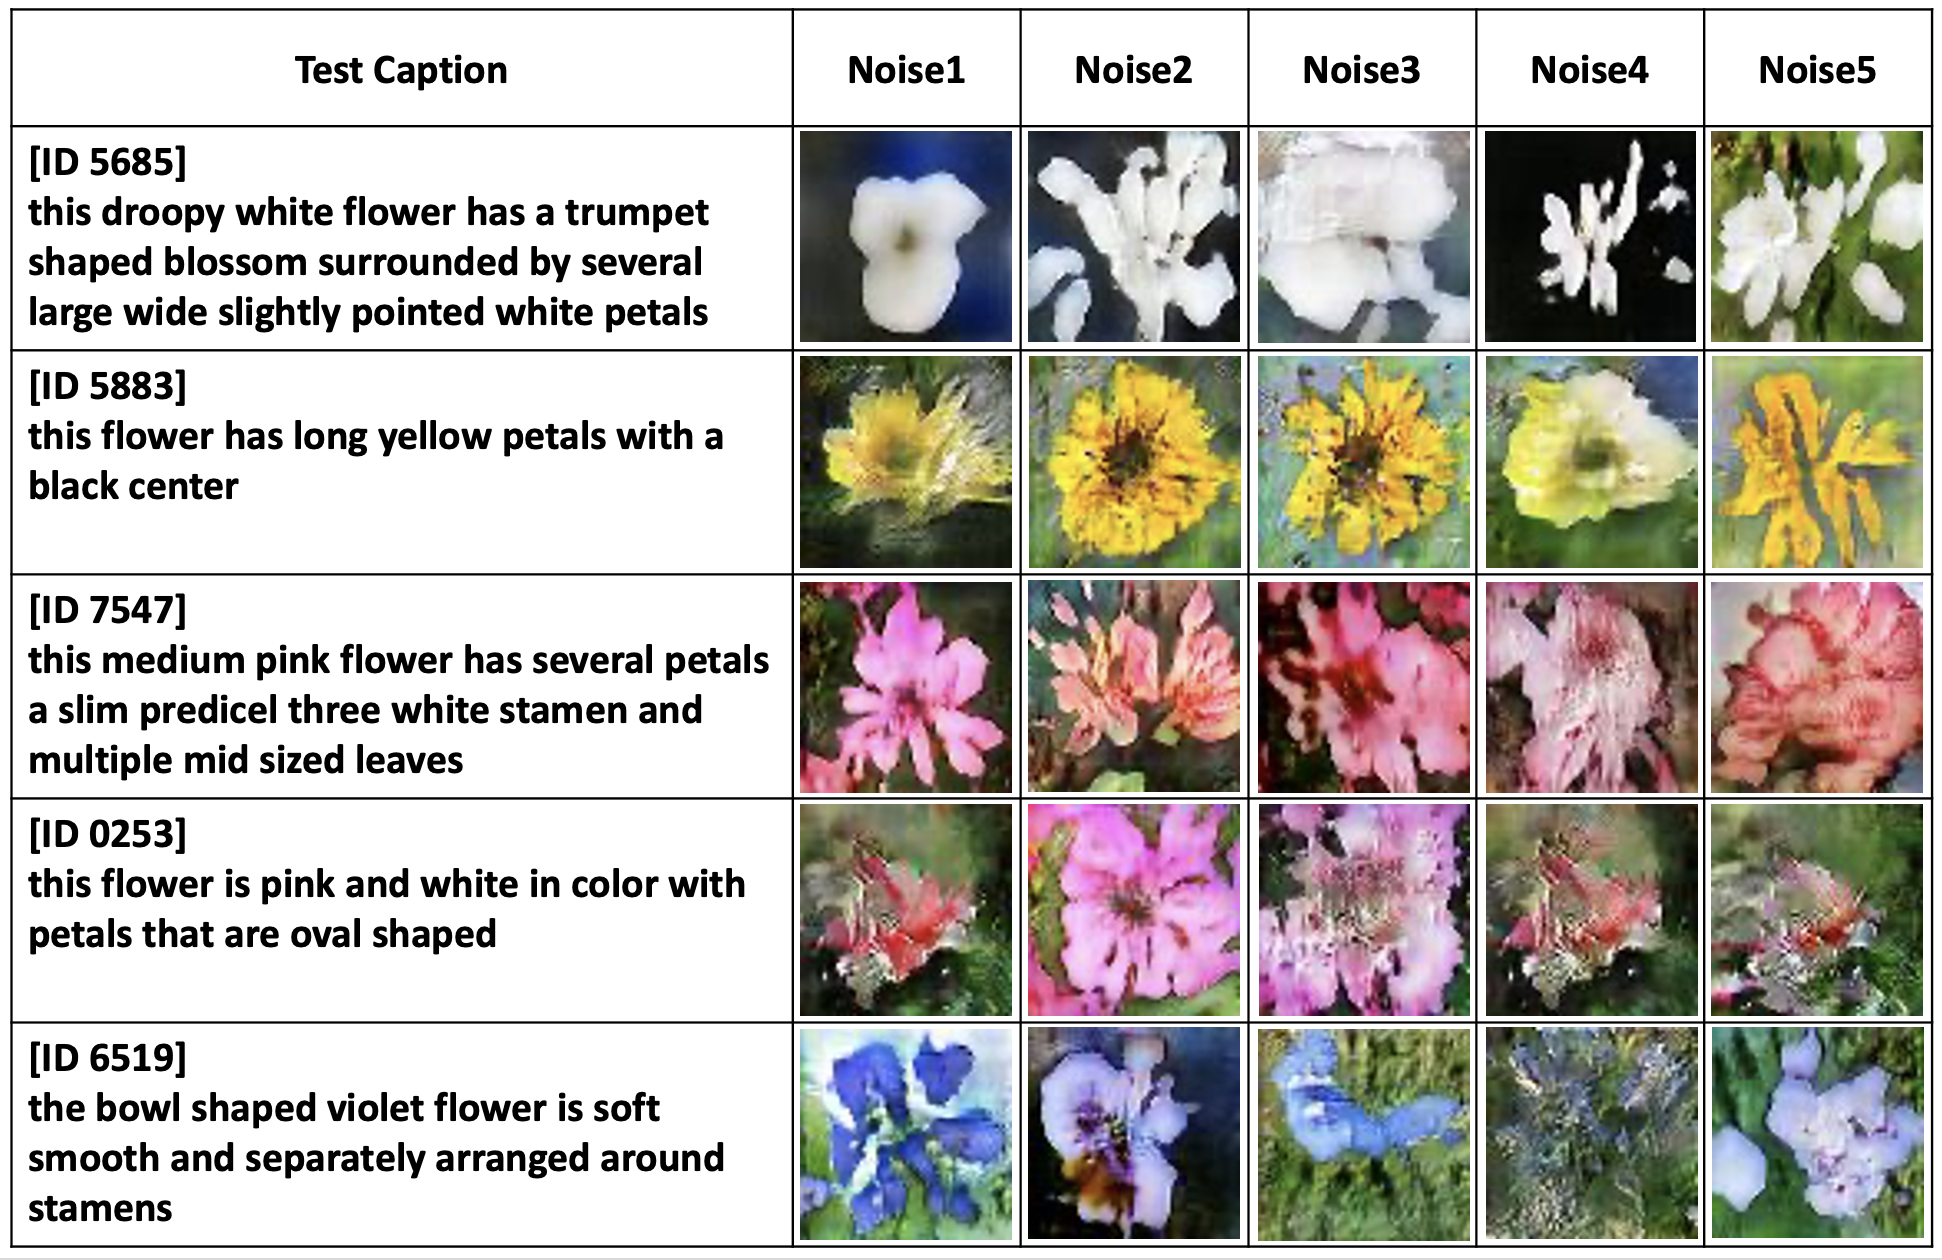

In [7]:
from IPython.display import Image
Image('generated_image.png')
